In [1]:
#preprocessing SANBS data

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("../1_data/private/SANBSdata.csv", error_bad_lines=False)



c:\Users\jagir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:

print(len(df.loc[df['Outcome'] =='DEFERRAL']))  # number of deferrals
print(len(df))#total observations


df.head()

556068
5115926


,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,...,race_group,race,Ferritin,category,DefCode,Def_start,Def_end,Deferral_permanent,EffectiveYr,EffectiveMo
0,1887945,2017-10-23 00:00:00.000,2017.0,10.0,1345.0,2.0,3622.0,26.0,F,Mobile Clinic,...,4,African Black,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN
1,1565252,2021-05-31 00:00:00.000,2021.0,5.0,1435.0,40.0,69.0,44.5,M,Mobile Clinic,...,2,Asian,24.9,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN
2,2299175,2015-03-10 00:00:00.000,2015.0,3.0,1445.0,6.0,140.0,19.6,M,Mobile Clinic,...,1,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN
3,2820016,2019-03-18 00:00:00.000,2019.0,3.0,1805.0,3.0,748.0,20.3,F,Mobile Clinic,...,1,White,0.0,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN
4,3450551,2022-09-06 00:00:00.000,2022.0,9.0,1336.0,3.0,951.0,20.5,M,Mobile Clinic,...,4,African Black,83.8,NaN,NaN,NaN,NaN,NoDeferral,NaN,NaN


In [5]:
#add donor history variables (already created and stored in don_hist.csv)
#see cox_params.xls for more information
df['Visit_Date']=pd.to_datetime(df['Visit_Date']).dt.strftime('%Y-%m-%dT%H:%M:%SZ') #covert to ISO -#2019-03-26T00:00:00Z

don_hist=pd.read_csv("../1_data/private/don_hist.csv")
df=pd.merge(df, don_hist[['DonorID', 'Visit_Date','cum_lifetime_donations','unit_rbc_loss','time_to_fu',
                          'rbc_loss_last_12_months', 'rbc_loss_last_24_months','days_since_last_rbc_loss', 
                          'days_since_last_drbc_loss']], how='left', on=["DonorID", "Visit_Date"])

df.head()

c:\Users\jagir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,...,Deferral_permanent,EffectiveYr,EffectiveMo,cum_lifetime_donations,unit_rbc_loss,time_to_fu,rbc_loss_last_12_months,rbc_loss_last_24_months,days_since_last_rbc_loss,days_since_last_drbc_loss
0,1887945,2017-10-23T00:00:00Z,2017.0,10.0,1345.0,2.0,3622.0,26.0,F,Mobile Clinic,...,NoDeferral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1565252,2021-05-31T00:00:00Z,2021.0,5.0,1435.0,40.0,69.0,44.5,M,Mobile Clinic,...,NoDeferral,NaN,NaN,40.0,1.0,119.0,2.0,3.0,69.0,3650.0
2,2299175,2015-03-10T00:00:00Z,2015.0,3.0,1445.0,6.0,140.0,19.6,M,Mobile Clinic,...,NoDeferral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2820016,2019-03-18T00:00:00Z,2019.0,3.0,1805.0,3.0,748.0,20.3,F,Mobile Clinic,...,NoDeferral,NaN,NaN,3.0,1.0,267.0,1.0,1.0,748.0,3650.0
4,3450551,2022-09-06T00:00:00Z,2022.0,9.0,1336.0,3.0,951.0,20.5,M,Mobile Clinic,...,NoDeferral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:

#add a column OUTCOME_TYPE that indicates hgb deferal, other deferral or completed donation to indicate deferral type

df.loc[(df['Outcome'] == 'DEFERRAL') & (df["category"]=='Haematocrit/Haemoglobin'), 'OUTCOME_TYPE'] = 'low hgb'
df.loc[(df['Outcome'] == "SUCCESSFUL DONATION"), 'OUTCOME_TYPE'] = 'completed'
df.loc[(df['Outcome'] == "DEFERRAL") & (df["category"]!='Haematocrit/Haemoglobin') , 'OUTCOME_TYPE'] = 'other deferral'
df['OUTCOME_TYPE'].fillna("no draw", inplace=True)

df.drop(df[df['Visit_Date'].isna()].index, inplace=True) #remove any missing visit dates

df["Visit_Date"] = df["Visit_Date"].astype("datetime64") #convert to date time object

df.sort_values(by=['DonorID', 'don_Sequence', 'Visit_Date'], axis = 0, inplace=True)

df['OUTCOME_TYPE'].value_counts()

completed         4451108
other deferral     308593
low hgb            247475
no draw            108748
Name: OUTCOME_TYPE, dtype: int64

In [7]:

#add censored column (indicates whether row is right censored) 0-censored, 1-notcensored
df['CENSORED']=np.where(df['DonorID'] == df['DonorID'].shift(-1), 1, 0)

#add time_to_return column (time between visits)
#if return exists -> difference between visit dates
#else difference between visit date and end of data collection 2022-12-31

df['time_to_return']= np.where(df['CENSORED']==1, (df['Visit_Date'].shift(-1)-df['Visit_Date'])/np.timedelta64(1, 'D'), (dt.datetime(2022, 12, 31)-df["Visit_Date"])/np.timedelta64(1, 'D'))
#df['time_to_return'].fillna((df['VISIT_DATE'].shift(-1)-df["VISIT_DATE"])/np.timedelta64(1, 'D'), inplace=True)



0.04055529211862565
0.0558079731461181
2429424
2666877


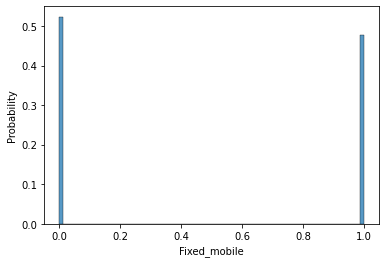

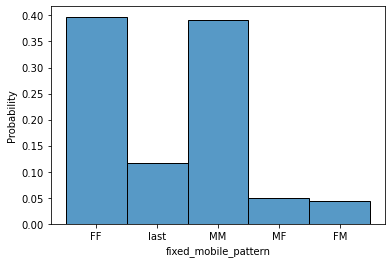

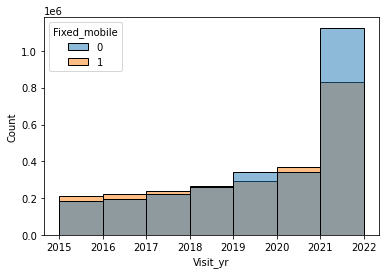

In [14]:
#Fixed-Mobile Donations Analysis

#plot number - mobile=0, fixed=1
fixed=df["Fixed"]
#sns.histplot(df, x="Fixed", stat="probability")
#sns.countplot(fixed)
#print(fixed.value_counts())

# group and remove some categories that are not fixed or mobile
# administrative site and apheresis clinic fall under fixed
# exclude others

df.drop(df[(df['Fixed']== 'Lapsed Clinic') | (df['Fixed']=='Processing Lab')| (df['Fixed']=='Unallocated') 
           | (df["Fixed"]== 'Laboratorium') |(df["Fixed"]=='Doctor')].index, inplace=True)

df['Fixed_mobile'] = np.where(df['Fixed'] == 'Mobile Clinic', 0, 1) #mobile is 0, fixed is 1
sns.histplot(df, x="Fixed_mobile", stat="probability")

#create a column to indicate 
    #1. mobile then mobile - mm
    #2. mobile then fixed -mf
    #3. fixed then fixed - ff
    #4. fixed then mobile - fm

df["FIXED_NEXT"] = np.where(df['DonorID'] == df['DonorID'].shift(-1), df['Fixed_mobile'].shift(-1), 10)
df.loc[((df['FIXED_NEXT']== 1) & (df['Fixed_mobile']== 1)), 'fixed_mobile_pattern'] = 'FF'

df.loc[((df['FIXED_NEXT']==0) & (df['Fixed_mobile']== 0)), 'fixed_mobile_pattern']= 'MM'

df.loc[((df['FIXED_NEXT']==0) & (df['Fixed_mobile']== 1)), 'fixed_mobile_pattern'] = 'FM'

df.loc[((df['FIXED_NEXT']==1) & (df['Fixed_mobile']== 0)), 'fixed_mobile_pattern']= 'MF'
df['fixed_mobile_pattern'].fillna('last', inplace=True)


#Plot fixed pattern
#create value count
plt.figure()
sns.histplot(df, x="fixed_mobile_pattern", stat="probability")
#sns.countplot(fixed_mobile)



# percent population fixed vs mobile by year
# - do people go back to the same mobile site?
# - how many people never completed donation?

plt.figure()
sns.histplot(data=df, x="Visit_yr", hue="Fixed_mobile", binwidth=1)

# the % of each resulting in hemoglobin deferral or other deferral

print(len(df.loc[((df['OUTCOME_TYPE']=="low hgb") & (df['Fixed_mobile']== 1))])/len(df.loc[(df['Fixed_mobile']==1)]))
print(len(df.loc[((df['OUTCOME_TYPE']=="low hgb") & (df['Fixed_mobile']== 0))])/len(df.loc[(df['Fixed_mobile']==0)]))

print(len(df.loc[(df['Fixed_mobile']==1)]))
print(len(df.loc[(df['Fixed_mobile']==0)]))



In [9]:
# Compute donation product for deferred donors - using the following criteria
 # 1) if donor only has WB then deferred donation is WB
 # 2) if next donation procedure is WB then deferred donation is WB/
 # 3) if previous donation procedure is WB then deferred donation is WB/
 # 4) if only donated one time and got deferred - WB
 
#prev successful 
#next successful

#df["don_proc_next"] = df.groupby("DonorID")["donation_product"].transform("shift")


df_don_proc=df.groupby("DonorID")["donation_product"].apply(list)
df["index"]=df.groupby("DonorID").cumcount()
df=pd.merge(df, df_don_proc, on="DonorID")

#missing=df.query("don_proc_imputed == 'DEF PROD'")
#len(missing)



In [17]:


df['don_proc_prev'] = np.where((df["donation_product_x"]=='DEF PROD') & ( df['index']== 0), 'First',
np.where((df["donation_product_x"]=='DEF PROD') & ('WB' in df.donation_product_y), 'WB',
np.where((df["donation_product_x"]=='DEF PROD') & (df['donation_product_y'].count('DEF PROD') == len(df['donation_product_y'])), 'Def Only', 
np.where(df["donation_product_x"]=='DEF PROD', 'NOT WB', '0'))))


'''


def conditions_for_prev(x, y, z):
    if (x != 'DEF PROD'): return 0
    if  (x=='DEF PROD') & (z== 0): return "First"
    elif (x=='DEF PROD') & ("WB" in y[:z]): return "WB"
    elif (x=='DEF PROD') & (y[:z].count('DEF PROD') == len(y[:z])): return "Def Only"
    else: return "Not WB"

func = np.vectorize(conditions_for_prev)
df['don_proc_prev'] = func(df["donation_product_x"], df['donation_product_y'], df['index'])
'''


ValueError: Series.count level is only valid with a MultiIndex

In [9]:
df.head(25)

,DonorID,Visit_Date,Visit_yr,Visit_Mo,donation_time,don_Sequence,col_Int,Visit_Age,sex,Fixed,...,EffectiveYr,EffectiveMo,OUTCOME_TYPE,CENSORED,time_to_return,Fixed_mobile,FIXED_NEXT,fixed_mobile_pattern,index,donation_product_y
0,18353,2015-07-07,2015.0,7.0,1453.0,20.0,521.0,38.9,M,Fixed Clinic,...,NaN,NaN,completed,1,67.0,Fixed,Fixed,FF,0,"[WB, WB, DEF PROD, DEF PROD, WB, WB, WB, WB, W..."
1,18353,2015-09-12,2015.0,9.0,1050.0,21.0,67.0,39.1,M,Fixed Clinic,...,NaN,NaN,completed,1,304.0,Fixed,Fixed,FF,1,"[WB, WB, DEF PROD, DEF PROD, WB, WB, WB, WB, W..."
2,18353,2016-07-12,2016.0,7.0,951.0,21.0,67.0,39.9,M,Fixed Clinic,...,2016.0,7.0,other deferral,1,1.0,Fixed,Fixed,FF,2,"[WB, WB, DEF PROD, DEF PROD, WB, WB, WB, WB, W..."
3,18353,2016-07-13,2016.0,7.0,1143.0,21.0,67.0,39.9,M,Fixed Clinic,...,2016.0,7.0,other deferral,1,341.0,Fixed,Fixed,FF,3,"[WB, WB, DEF PROD, DEF PROD, WB, WB, WB, WB, W..."
4,18353,2017-06-19,2017.0,6.0,1225.0,22.0,646.0,40.9,M,Fixed Clinic,...,NaN,NaN,completed,1,379.0,Fixed,Fixed,FF,4,"[WB, WB, DEF PROD, DEF PROD, WB, WB, WB, WB, W..."
5,18353,2018-07-03,2018.0,7.0,930.0,23.0,379.0,41.9,M,Fixed Clinic,...,NaN,NaN,completed,1,72.0,Fixed,Fixed,FF,5,"[WB, WB, DEF PROD, DEF PROD, WB, WB, WB, WB, W..."
6,18353,2018-09-13,2018.0,9.0,1118.0,24.0,72.0,42.1,M,Fixed Clinic,...,NaN,NaN,completed,1,68.0,Fixed,Fixed,FF,6,"[WB, WB, DEF PROD, DEF PROD, WB, WB, WB, WB, W..."
7,18353,2018-11-20,2018.0,11.0,1137.0,25.0,68.0,42.3,M,Fixed Clinic,...,NaN,NaN,completed,1,67.0,Fixed,Fixed,FF,7,"[WB, WB, DEF PROD, DEF PROD, WB, WB, WB, WB, W..."
8,18353,2019-01-26,2019.0,1.0,1240.0,26.0,67.0,42.5,M,Fixed Clinic,...,NaN,NaN,completed,1,59.0,Fixed,Fixed,FF,8,"[WB, WB, DEF PROD, DEF PROD, WB, WB, WB, WB, W..."
9,18353,2019-03-26,2019.0,3.0,1245.0,27.0,59.0,42.6,M,Fixed Clinic,...,NaN,NaN,completed,1,57.0,Fixed,Fixed,FF,9,"[WB, WB, DEF PROD, DEF PROD, WB, WB, WB, WB, W..."


In [10]:
#remove outcomes with def_end < visit_date
df.drop(df[df['Visit_Date'] > df['Def_end']].index, inplace=True)

# add variable first time -> 1- first time, 0-repeat

df['first_time'] = np.where(df['index'] == 0, 1, 0)

In [ ]:
#compute time_to_return with shifts for completed donation: subtract 56 days 

df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'completed', (df['time_to_return'] - 56), df['time_to_return'])

#compute time_to_return with shifts for other donations
#first covert eligibilty year and month to a datetime object

df["Def_end"] = df["Def_end"].astype("datetime64")

#hgb deferrals
df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'low hgb', (df['time_to_return'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])

#other deferrals
df['time_to_return'] = np.where(df['OUTCOME_TYPE'] == 'other deferral', (df['time_to_return'] - ((df['Def_end'] - df['Visit_Date'])/np.timedelta64(1, 'D'))), df['time_to_return'])
df['time_to_return'].isna().sum()

In [11]:
#remove permanent deferrals
df.drop(df[df.Deferral_permanent == 'Perm'].index, inplace=True)
df.drop(df[(df['OUTCOME_TYPE'] == 'other deferral') & (df['Deferral_permanent'] == 'NoDeferral')].index, inplace=True)


In [12]:
# documenting some errors in data

df['time_to_return'].isnull().sum()

#df_end=df.loc[df['Visit_Date'] > df['Def_end']]
#print(len(df_end))
#df_end.head(25).to_csv('../4_output/def_end_error.csv')

#df_def=df.loc[(df['Deferral_permanent'] == 'NoDeferral') & (df['OUTCOME_TYPE'] == "other deferral")]
#df_def.head(25).to_csv('../4_output/def_permanent_error.csv')

#df_neg=df.loc[ (df['time_to_return']<0)]
#print(len(df_neg))
#df_neg.head(-25)



0

In [13]:
df.to_csv(("../1_data/private/preprocessed_data.csv"), index=False)
